## Install dependencies

In [1]:
!pip install langgraph langsmith langchain langchain_groq langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 70.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.1/489.1 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 1.2.1
    Uninstalling langchain-core-1.2.1:
      Successfully uninstalled langchain-core-1.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google

In [2]:
!pip install langchain-google-genai tavily-python google-generativeai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.3/53.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.6/426.6 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.3/233.3 kB 14.4 MB/s eta 0:00:00
  Attempting uninstall: google-auth
    Found existing installation: google-auth 2.43.0
    Uninstalling google-auth-2.43.0:
      Successfully uninstalled google-auth-2.43.0
  Attempting uninstall: google-genai
    Found existing installation: google-genai 1.55.0
    Uninstalling google-genai-1.55.0:
      Successfully uninstalled google-genai-1.55.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires google-auth==2.43.0, but you have google-auth 2.45.0 which is incompatible.
google-colab 1.0.0 requires requests==2.32.4, b

## Import library

In [3]:
from typing import Annotated
from typing_extensions import TypedDict
from google.colab import userdata
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import display, Image
import os

## Tools

In [4]:
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')
tool_search = TavilySearchResults(
    max_results=5,
    include_domains=["kompas.com", "detik.com", "cnnindonesia.com", "turnbackhoax.id",
                     "cekfakta.com", "liputan6.com", "tempo.co"]
)
tools = [tool_search]

/tmp/ipython-input-849519488.py:2: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tool_search = TavilySearchResults(


In [5]:
class State(TypedDict):
    messages:Annotated[list, add_messages]

In [6]:
graph_builder = StateGraph(State)

In [7]:
groq_api_key = userdata.get('GROQ_API_KEY')
llm = ChatGroq(groq_api_key=groq_api_key, model_name="llama-3.3-70b-versatile")
llm

ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 32768, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x7b71a578d7c0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7b71a4c310d0>, model_name='llama-3.3-70b-versatile', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [8]:
llm_with_tools = llm.bind_tools(tools=tools)

In [9]:
def chatbot(state=State):
  messages = state['messages']
  if not isinstance(messages[0], SystemMessage):
    sys_msg = SystemMessage(content="""
            Kamu adalah Fact Checker AI yang kritis. Tugasmu memverifikasi klaim user.

            LANGKAH KERJAMU:
            1. Jika user memberikan klaim berita, GUNAKAN TOOL search untuk mencari fakta di media terpercaya.
            2. Jangan menjawab berdasarkan pengetahuanmu sendiri saja, WAJIB validasi pakai tool.
            3. Setelah mendapatkan hasil search, berikan kesimpulan: VALID jika klaim berita sesuai dengan fakta, HOAX jika tidak sesuai fakta, atau MISLEADING jika kesalahpahaman.
            4. Sertakan link referensi.
        """)
    messages = [sys_msg] + messages

  response = llm_with_tools.invoke(messages)
  return {"messages":[response]}

In [10]:
tool_node=ToolNode(tools=tools)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)
graph_builder.add_edge(START, "chatbot")


graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

graph_builder.add_edge("tools", "chatbot")


In [11]:
graph = graph_builder.compile()

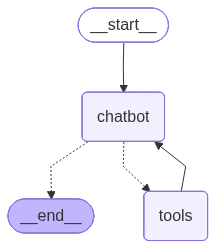

In [12]:
try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass

In [13]:
def run_checker(query):
    initial_state = {"messages": [HumanMessage(content=query)]}
    final_response = None

    for event in graph.stream(initial_state):
        for key, value in event.items():
            if key == "chatbot":
                print("Agent berpikir...")
                msg = value["messages"][-1]
                if msg.tool_calls:
                    print(f"Memutuskan mencari: {msg.tool_calls[0]['args']}")
                else:
                    final_response = msg.content
            elif key == "tools":
                print("Mengambil data dari internet...")

    print("\n" + "="*40)
    print("KESIMPULAN:")
    print("="*40)
    print(final_response)

run_checker("Apakah Ferry Irwandi menuduh TNI merekayasa kerusuhan")

Agent berpikir...
Memutuskan mencari: {'query': 'Ferry Irwandi menuduh TNI merekayasa kerusuhan'}
Mengambil data dari internet...
Agent berpikir...

KESIMPULAN:
Berdasarkan hasil pencarian, klaim bahwa Ferry Irwandi menuduh TNI merekayasa kerusuhan adalah **HOAX**. Video yang beredar di media sosial yang menampilkan Ferry Irwandi menuduh TNI sebagai dalang kerusuhan merupakan hasil rekayasa berbasis artificial intelligence (AI) dengan probabilitas 99,9 persen. 

Referensi: 
https://cekfakta.com/focus/29186 
https://www.kompas.com/cekfakta/read/2025/09/22/130300582/hoaks-ferry-irwandi-tuduh-tni-dalang-kerusuhan 
https://en.tempo.co/read/2048299/tni-claims-ferry-irwandis-content-misleading-and-disrupts-stability 
https://www.detik.com/bali/berita/d-8104461/dugaan-kriminalisasi-tni-terhadap-ferry-irwandi 
https://www.cnnindonesia.com/nasional/20250909120739-12-1271599/koalisi-sipil-kritik-tni-bidik-ferry-irwandi-militerisasi-ruang-siber
